# Predicting Credit Defaults

In this project, the aim is to predict bank customer defaults (label 0: Non-Default, label 1: Default) depending on a plethora of features. In this process, I would like to both achieve the highest accuracy possible, the lowest recall possible on Customer defaults, while also understanding the main features that can lead to a customer default. To achieve both of my goals, I decided to follow this pipeline:

- Understand our independent features, as well as our target variable.
- Prepare and process our dataset.
- Feature Engineering.
- Machine Learning Models, Hyperparameter tunning, and Evaluation.

<b>Table of content for Jupyter Notebook</b>

1. Data Loading and Exploratory Data Analysis
2. Investigating Missing Values
3. Handling Outliers and Correcting Skewness
4. Encoding Categorical Variables
5. Handling the Imbalance in the dataset
5. Running Logistic Regression
6. Conclusions and Evaluations

## Data Loading and Exploratory Data Analysis

We begin by loading our dataset and inspecting wether we have duplicated rows or missing values.

In [2]:
import pandas as pd
import numpy as np

path = 'data\Loan_Default.csv'
df = pd.read_csv(path)
display(df.head())

# Printing general information
df.info()

# Understand shape of data
print(f'\nShape: {df.shape}')

# Check for duplicates
num_duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

# Check for missing values
num_missing = df.isnull().sum().sum()
print(f'Number of missing values: {num_missing}')

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

We have no duplicate rows, but we have a lot of missing values. We will deal with missing values later in the notebook.

## Dividing and investigating the dataset by datatype

The absence of datset documentation renders necessary some further analysis, which has been carried out in this section. The dataset was divided into datatypes, numerical and categorical, with the latter further split into dummy variables and other multi-class variables.

In [3]:
# Investigating column datatypes
object_cols = list(df.select_dtypes('object').columns)
int_cols = list(df.select_dtypes('int').columns)
float_cols = list(df.select_dtypes('float').columns)

print(f'Non-numeric columns: {object_cols}\n')
print(f'Numeric integer columns: {int_cols}\n')
print(f'Numeric decimal columns: {float_cols}')

Non-numeric columns: ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region', 'Security_Type']

Numeric integer columns: ['ID', 'year', 'loan_amount', 'Credit_Score', 'Status']

Numeric decimal columns: ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'LTV', 'dtir1']


In [4]:
# Checking number of unique values for each column
uniqueness = df.nunique()
n_unique = pd.DataFrame(uniqueness).reset_index()
n_unique.rename(columns={0: 'unique_values'}, inplace=True)

n_unique

,index,unique_values
0,ID,148670
1,year,1
2,loan_limit,2
3,Gender,4
4,approv_in_adv,2
5,loan_type,3
6,loan_purpose,4
7,Credit_Worthiness,2
8,open_credit,2
9,business_or_commercial,2


#### Non-numeric Columns

In [5]:
# Returning potential dummy variables and their values
uni_df_dummy = n_unique.loc[n_unique['unique_values'] <= 2]
dummy_names = uni_df_dummy.iloc[1:-1,0]

for el in dummy_names:
    print(f'{el} = {[x for x in df[el].unique() if pd.notna(x)]}\n')

loan_limit = ['cf', 'ncf']

approv_in_adv = ['nopre', 'pre']

Credit_Worthiness = ['l1', 'l2']

open_credit = ['nopc', 'opc']

business_or_commercial = ['nob/c', 'b/c']

Neg_ammortization = ['not_neg', 'neg_amm']

interest_only = ['not_int', 'int_only']

lump_sum_payment = ['not_lpsm', 'lpsm']

construction_type = ['sb', 'mh']


Secured_by = ['home', 'land']

co-applicant_credit_type = ['CIB', 'EXP']

submission_of_application = ['to_inst', 'not_inst']

Security_Type = ['direct', 'Indriect']


In [6]:
# Returning categorical variables with values between 3 and 7 to perform encoding on
uni_df_cat = n_unique.loc[(n_unique['unique_values'] > 2) & (n_unique['unique_values'] <= 7)]
cat_var = uni_df_cat.iloc[1:,0]

for el in cat_var:
    print(f'{el} = {[x for x in df[el].unique() if pd.notna(x)]}\n')

loan_type = ['type1', 'type2', 'type3']

loan_purpose = ['p1', 'p4', 'p3', 'p2']

occupancy_type = ['pr', 'sr', 'ir']

total_units = ['1U', '2U', '3U', '4U']

credit_type = ['EXP', 'EQUI', 'CRIF', 'CIB']

age = ['25-34', '55-64', '35-44', '45-54', '65-74', '>74', '<25']

Region = ['south', 'North', 'central', 'North-East']


#### Numeric Columns

In [7]:
# Investigating ranges of numerical values
df_num = df.select_dtypes(np.number)
num_var = list(df_num)

def range_numcol(df, colname):
    return (df[colname].min(), df[colname].max())

for el in num_var:
    print(f'{el} --> {range_numcol(df, el)}\n')

ID --> (24890, 173559)

year --> (2019, 2019)

loan_amount --> (16500, 3576500)

rate_of_interest --> (0.0, 8.0)

Interest_rate_spread --> (-3.638, 3.357)

Upfront_charges --> (0.0, 60000.0)

term --> (96.0, 360.0)

property_value --> (8000.0, 16508000.0)

income --> (0.0, 578580.0)

Credit_Score --> (500, 900)

LTV --> (0.967478198, 7831.25)

Status --> (0, 1)

dtir1 --> (5.0, 61.0)


## Visualizing the Dataset's Features

This next step is needed is to have a better understanding about the shape and composition of our data.
To this end, we would like to quickly visualize:
- The distribution of every feature,
- The imbalances and skewness,


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import numpy as np

def plot_columns(df_to_plot):
    """
    Function to plot each column of a dataframe.
    For numerical data: creates a boxplot and histogram.
    For categorical data:
        - Bar chart if less than or equal to 15 categories.
        - Text info about the number of categories if more than 15 categories.

    Parameters:
    df_to_plot: DataFrame
        The dataframe to visualize.
    """

    print(f'\n\nShape of the dataframe: {df_to_plot.shape}\n\n\n')

    # Set the aesthetics for the plots
    sns.set(style="darkgrid")

    # Number of columns for the main grid
    n_cols = 3

    # Adjust the number of rows considering the layout for numerical data
    n_rows = int(np.ceil(len(df_to_plot.columns) / n_cols)) * 2

    # Create grid
    plt.figure(figsize=(15, n_rows * 2))
    grid = gridspec.GridSpec(n_rows, n_cols, figure=plt.gcf(), hspace=1.5, wspace=0.5)

    # Loop through each column in the dataframe
    for i, column in enumerate(df_to_plot.columns):
        # Calculate row index considering the new layout
        row_idx = (i // n_cols) * 2
        col_idx = i % n_cols

        # Numeric data
        if np.issubdtype(df_to_plot[column].dtype, np.number):
            # Nested grid for so that histogram is 7 times higher than boxplot
            nested_grid = gridspec.GridSpecFromSubplotSpec(8, 1, subplot_spec=grid[row_idx:row_idx + 2, col_idx], hspace=0.1)

            # Boxplot
            ax_box = plt.subplot(nested_grid[0])
            sns.boxplot(x=df_to_plot[column], ax=ax_box)
            ax_box.set_title(column, fontsize=16)
            ax_box.set_xlabel('')

            # Histogram
            ax_hist = plt.subplot(nested_grid[1:])
            sns.histplot(df_to_plot[column], bins=30, ax=ax_hist)
            ax_hist.set_title("")
            ax_hist.set_xlabel('')

        else:
            # Categorical data
            if df_to_plot[column].nunique() <= 15:
                # Bar chart
                ax_bar = plt.subplot(grid[row_idx:row_idx + 2, col_idx])
                sns.countplot(x=df_to_plot[column], ax=ax_bar)
                ax_bar.set_title(column, fontsize=16)
                ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45)
                ax_bar.set_xlabel('')

            else:
                # Display text information for categories more than 15
                ax_text = plt.subplot(grid[row_idx:row_idx + 2, col_idx])
                top_categories = df_to_plot[column].value_counts().head(5)
                text_str = f'Number of categories: {df_to_plot[column].nunique()}\n\nTop 5 categories:\n{top_categories.to_string()}'
                ax_text.text(0.5, 0.5, text_str, ha='center', va='center', fontsize=12)
                ax_text.axis('off')
                ax_text.set_title(column, fontsize=16)

    # Adjust layout to fit everything
    plt.tight_layout()
    plt.show()



Shape of the dataframe: (148670, 33)



C:\Users\Markou\AppData\Local\Temp\ipykernel_31880\3558614591.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


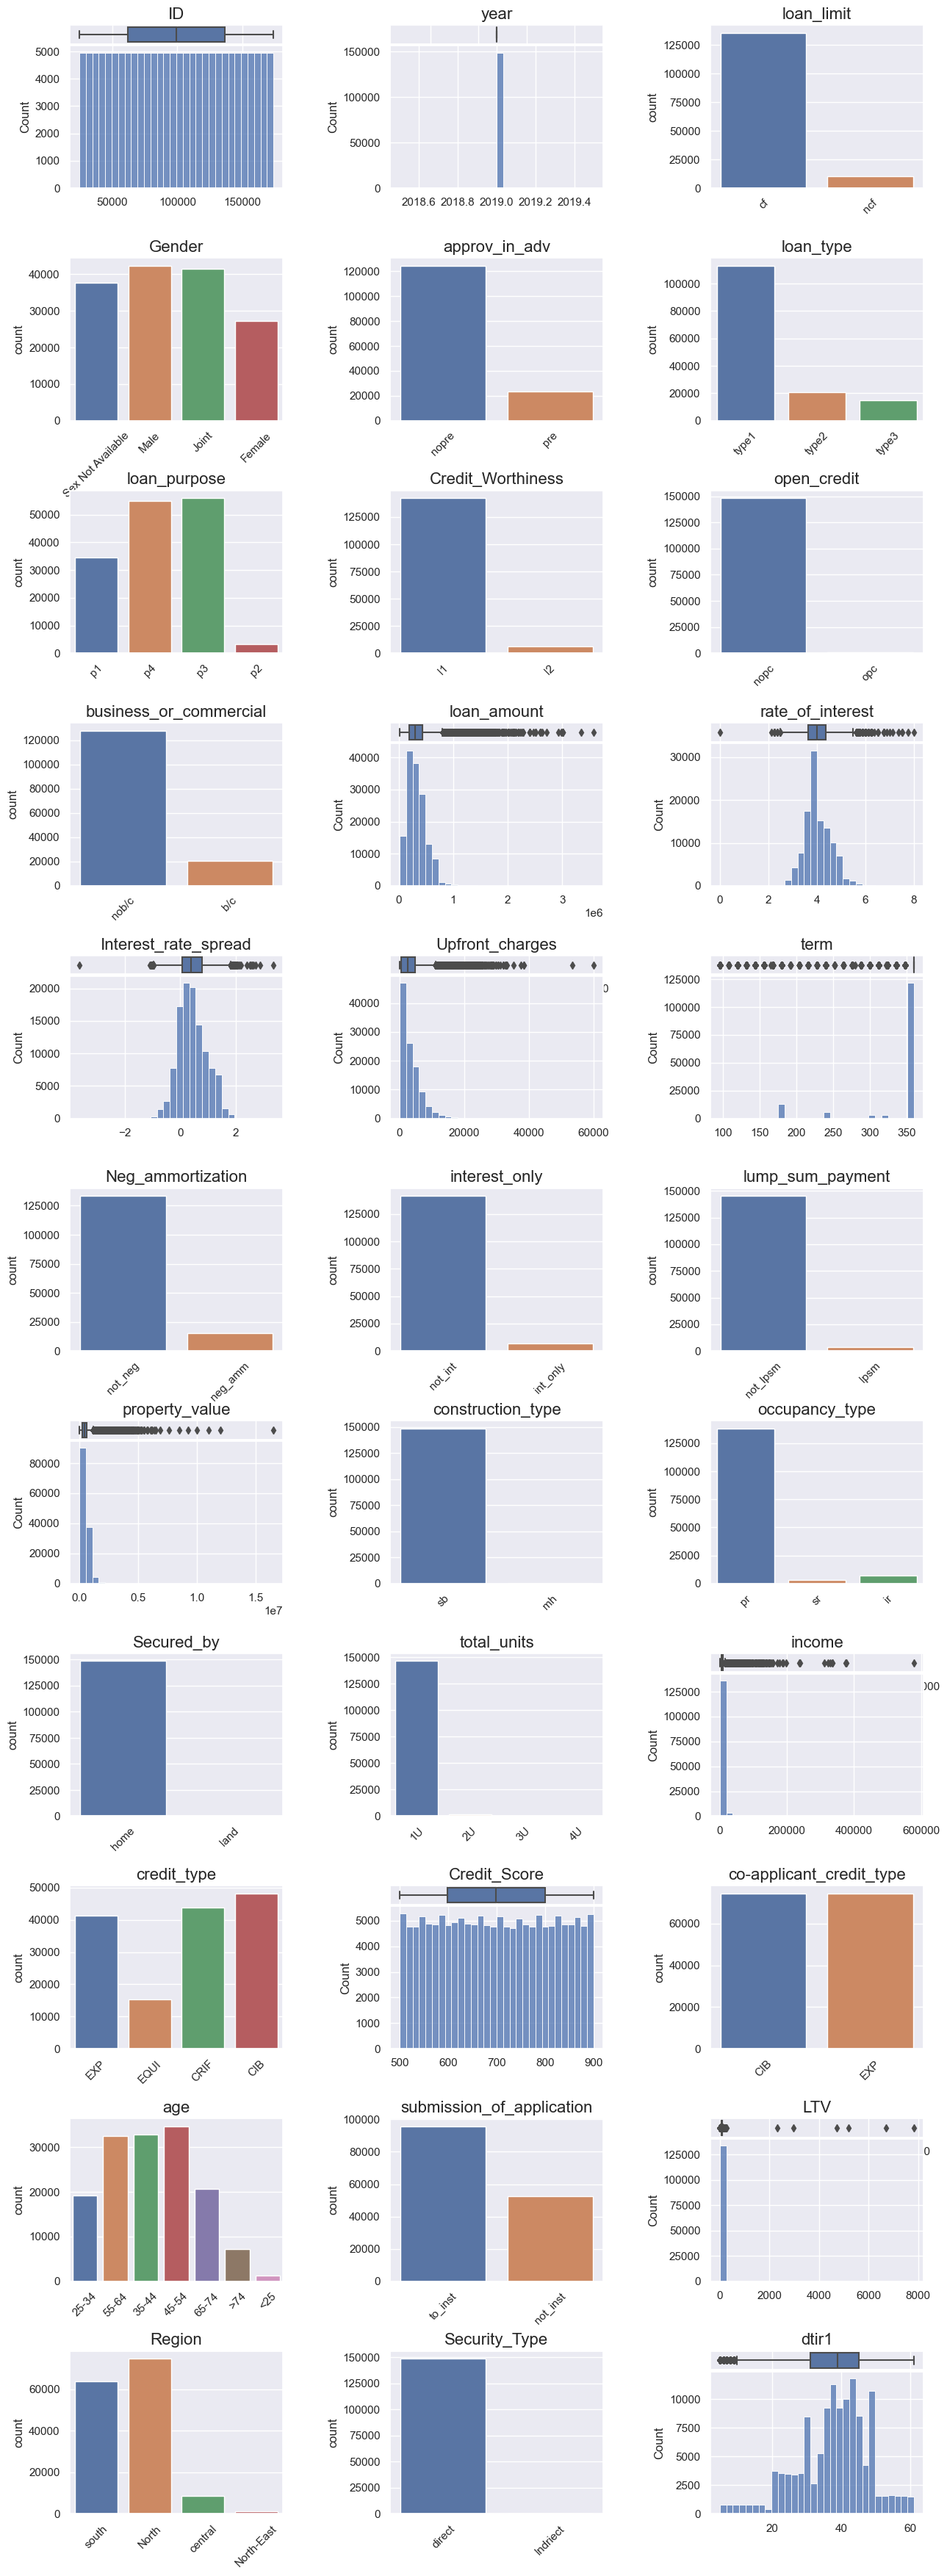

In [9]:
plot_columns(df.drop(columns='Status'))

From this first rough analysis it is immediately clear that the feature year can be removed, since it has a single value through the whole dataset.

Furthermore, we notice that many numerical variables present outliers (loan_amount, rate_of_interest, Upfront_charges, property_value, income, LTV) and some other ones are also skewed (loan_amount, Upfront_charges, property_value).

In [10]:
df = df.drop(columns = 'year')

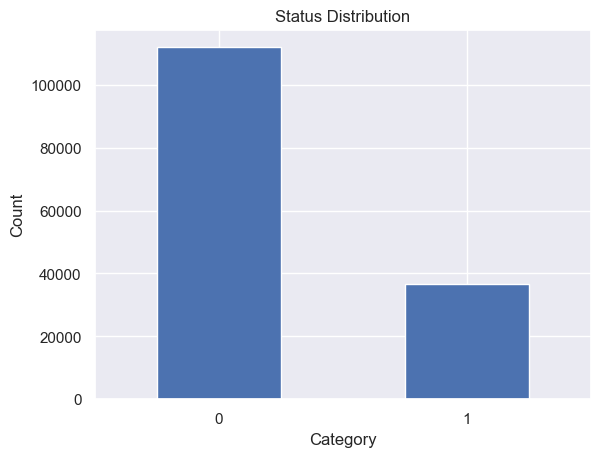

0    112031
1     36639
Name: Status, dtype: int64

In [11]:
value_counts = df['Status'].value_counts()

# Create a bar chart
value_counts.plot(kind='bar')

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Status Distribution')
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)  # Ensures the x-axis has labels 0 and 1

# Show the plot
plt.show()

display(value_counts)

This plot shows that the dataset is heavily imbalanced, with Category 1, representing loans that default, having a much lower count than Category 0, loans that don't default.

This is to be expected, as loan defaults represent a much rarer occurrence than loans that don't. In order to be able to gain meaningful insights, we will handle this issue later in the notebook.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import numpy as np

def plot_columns_against_target(df_to_plot, target_variable):
    """
    Function to plot each column of a dataframe against a categorical target variable.
    For numerical data: creates a boxplot and histogram against the target variable.
    For categorical data:
        - Bar chart if less than or equal to 15 categories against the target variable.
        - Text info about the number of categories if more than 15 categories.

    Parameters:
    df_to_plot: DataFrame
        The dataframe to visualize.
    target_variable: str
        The name of the categorical target variable.
    """

    print(f'\n\nShape of the dataframe: {df_to_plot.shape}\n\n\n')

    # Set the aesthetics for the plots
    sns.set(style="darkgrid")

    # Number of columns for the main grid
    n_cols = 3

    # Adjust the number of rows considering the layout for numerical data
    n_rows = int(np.ceil(len(df_to_plot.columns) / n_cols)) * 2

    # Create grid
    plt.figure(figsize=(15, n_rows * 2))
    grid = gridspec.GridSpec(n_rows, n_cols, figure=plt.gcf(), hspace=1.5, wspace=0.5)

    # Loop through each column in the dataframe
    for i, column in enumerate(df_to_plot.columns):
        # Calculate row index considering the new layout
        row_idx = (i // n_cols) * 2
        col_idx = i % n_cols

        # Numeric data
        if np.issubdtype(df_to_plot[column].dtype, np.number):
            # Nested grid for so that histogram is 7 times higher than boxplot
            nested_grid = gridspec.GridSpecFromSubplotSpec(8, 1, subplot_spec=grid[row_idx:row_idx + 2, col_idx], hspace=0.1)

            # Boxplot against the target variable
            ax_box = plt.subplot(nested_grid[0])
            sns.boxplot(x=target_variable, y=df_to_plot[column], data=df_to_plot, ax=ax_box)
            ax_box.set_title(f"{column} vs. {target_variable}", fontsize=16)
            ax_box.set_xlabel('')
            ax_box.set_ylabel('')

            # Histogram against the target variable
            ax_hist = plt.subplot(nested_grid[1:])
            sns.histplot(data=df_to_plot, x=df_to_plot[column], bins=30, hue=target_variable, ax=ax_hist, multiple='stack')
            ax_hist.set_title("")
            ax_hist.set_xlabel('')

        else:
            # Categorical data
            if df_to_plot[column].nunique() <= 15:
                # Bar chart against the target variable
                ax_bar = plt.subplot(grid[row_idx:row_idx + 2, col_idx])
                sns.countplot(x=df_to_plot[column], hue=target_variable, data=df_to_plot, ax=ax_bar)
                ax_bar.set_title(f"{column} vs. {target_variable}", fontsize=16)
                ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45)
                ax_bar.set_xlabel('')

            else:
                # Display text information for categories more than 15
                ax_text = plt.subplot(grid[row_idx:row_idx + 2, col_idx])
                top_categories = df_to_plot[column].value_counts().head(5)
                text_str = f'Number of categories: {df_to_plot[column].nunique()}\n\nTop 5 categories:\n{top_categories.to_string()}'
                ax_text.text(0.5, 0.5, text_str, ha='center', va='center', fontsize=12)
                ax_text.axis('off')
                ax_text.set_title(f"{column} vs. {target_variable}", fontsize=16)

    # Adjust layout to fit everything
    plt.tight_layout()
    plt.show()



Shape of the dataframe: (148670, 32)



C:\Users\Markou\AppData\Local\Temp\ipykernel_31880\2831626611.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


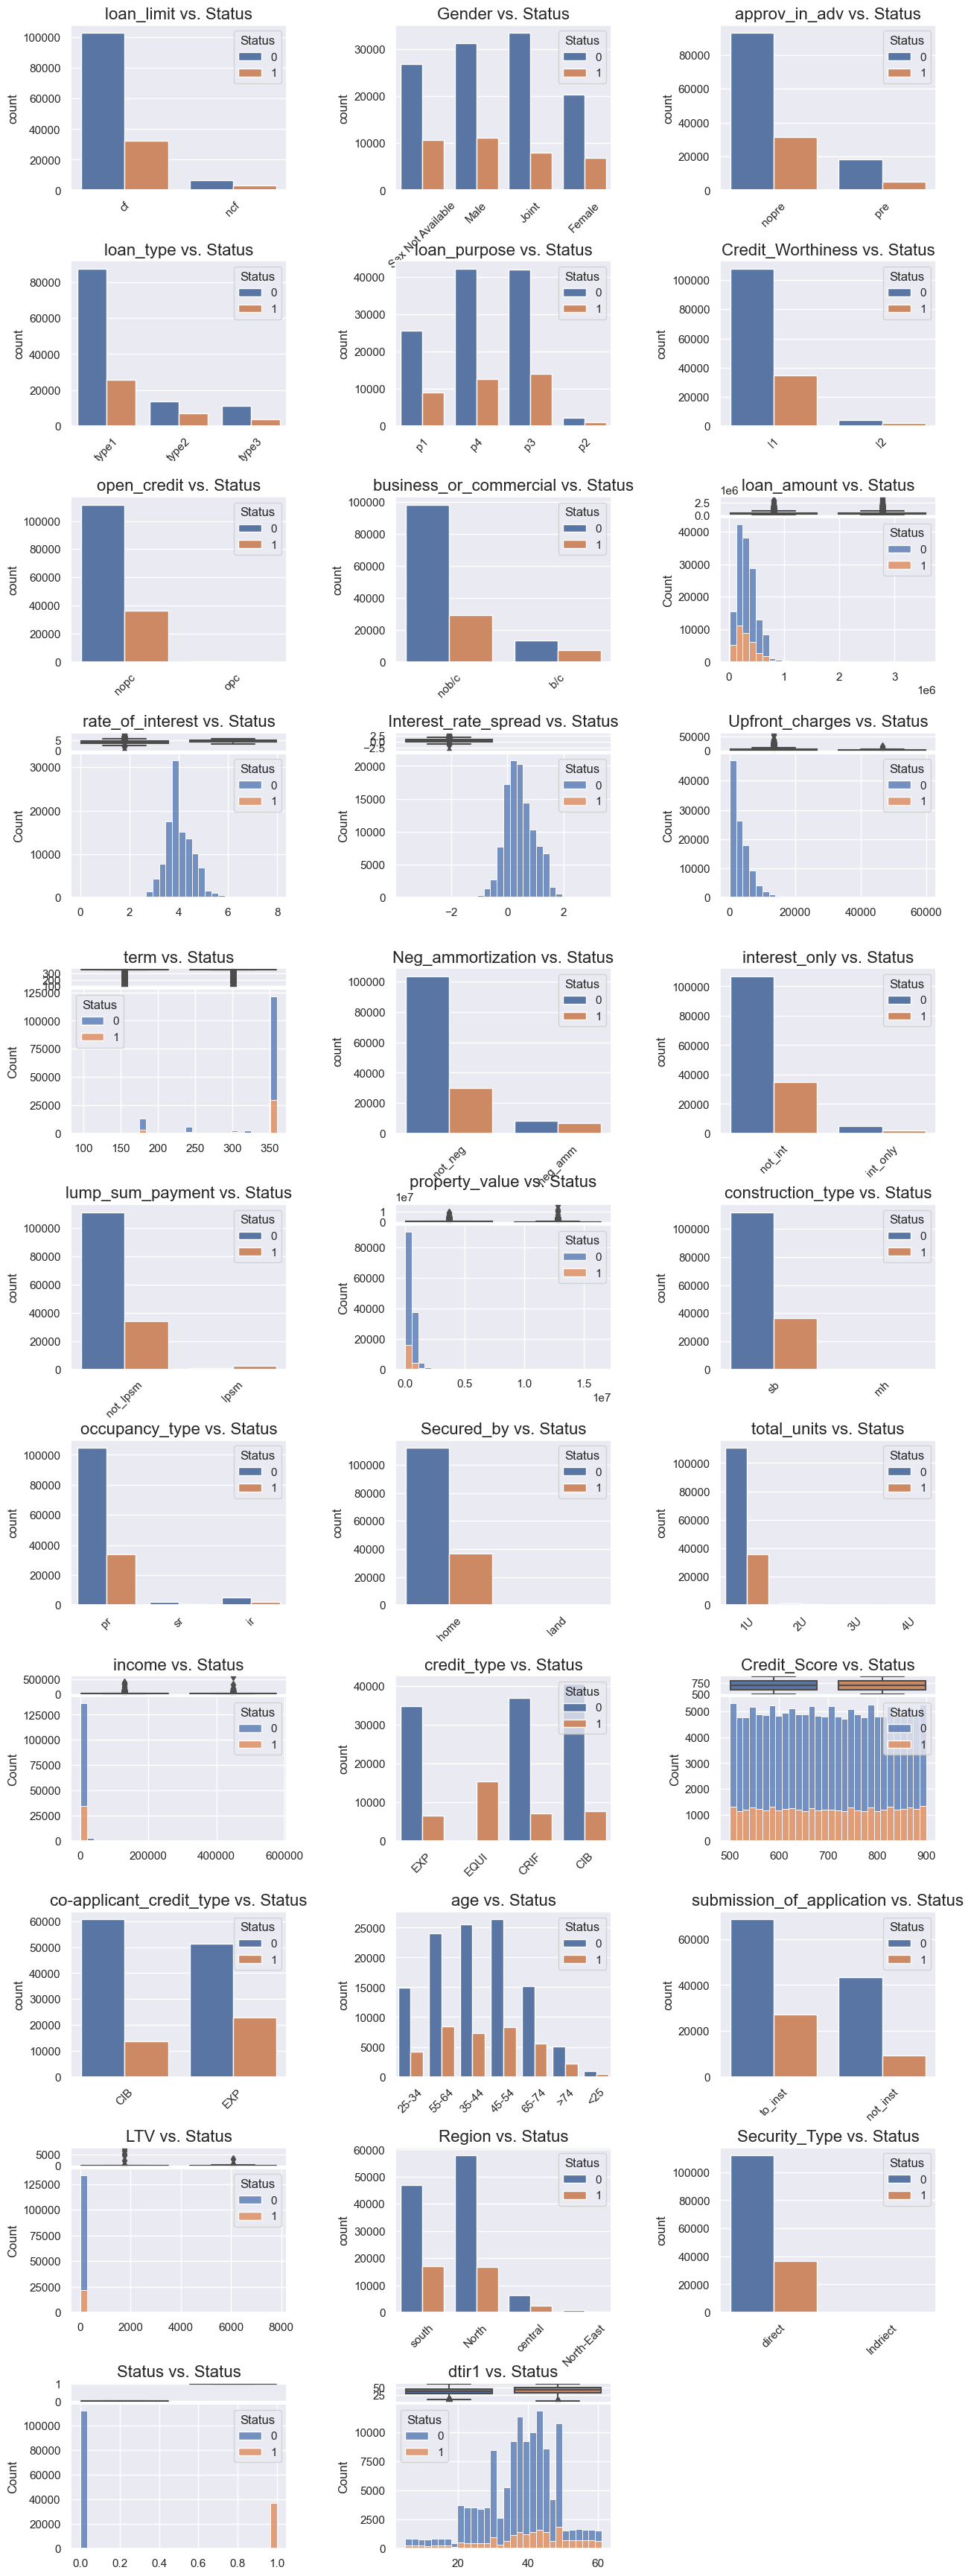

In [13]:
# Example usage
plot_columns_against_target(df.drop(columns=['ID']), "Status")

These plot serves as further testimony of the imbalances of our dataset.

## Investigating Missing Values

We start by investigating the features that exibit missing values, by collecting them in a comprehensive table showing the number of null values per column and their percentage over the size of the dataset.

,col_name,data_type,null_num,null_perc
1,loan_limit,object,3344,2.25
3,approv_in_adv,object,908,0.61
5,loan_purpose,object,134,0.09
10,rate_of_interest,float64,36439,24.51
11,Interest_rate_spread,float64,36639,24.64
12,Upfront_charges,float64,39642,26.66
13,term,float64,41,0.03
14,Neg_ammortization,object,121,0.08
17,property_value,float64,15098,10.16
22,income,float64,9150,6.15


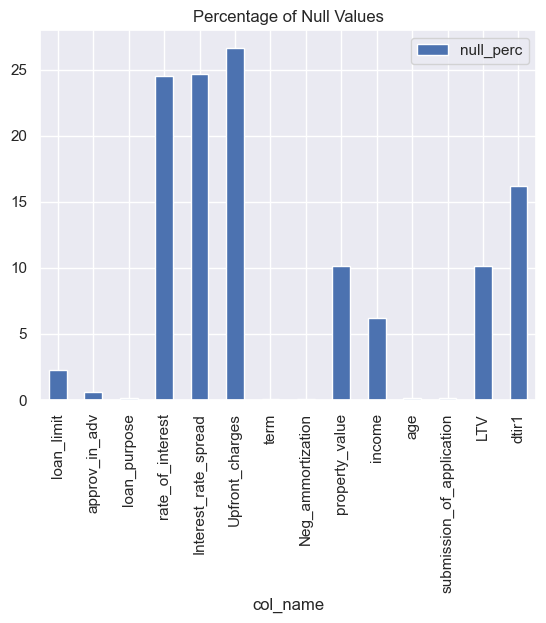

In [14]:
# Displaying the number and percentage of missing values for columns with missing values
def null_val_info(df):
    num_rows = df.shape[0]
    perc_list = [(col, df[col].dtype, df[col].isnull().sum(), round((df[col].isnull().sum()/num_rows)*100,2)) for col in df.columns]

    null_val = pd.DataFrame(perc_list).rename(columns={0:'col_name', 1:'data_type', 2:'null_num', 3:'null_perc'})
    null_val = null_val.loc[null_val['null_num'] > 0]

    null_val.plot(x = 'col_name', y = 'null_perc', kind = 'bar', rot = 90, title = 'Percentage of Null Values')

    return null_val

null_val_info(df)

It is very surprising to see that 'Interest_rate_spread' has a number of missing values equal to the number of rows classified with 'Status' = 1. This prompted further analysis, specifically visualizing missing values divided by classification class.

In [15]:
def status_null_val(df, status_col='Status', status_value=1):
    # Filter the DataFrame to include only rows with 'Status 1'
    df_filtered = df[df[status_col] == status_value]

    num_rows = df_filtered.shape[0]
    perc_list = [(col, df_filtered[col].dtype, df_filtered[col].isnull().sum(), round((df_filtered[col].isnull().sum()/num_rows)*100, 2)) for col in df_filtered.columns]

    null_val = pd.DataFrame(perc_list).rename(columns={0: 'col_name', 1: 'data_type', 2: 'null_num', 3: 'null_perc'})
    null_val = null_val.loc[null_val['null_num'] > 0].sort_values('null_num', ascending=False)

    count_status = (df['Status'] == status_value).sum()

    null_val.plot(x = 'col_name', y = 'null_perc', kind = 'bar', rot = 90, title = 'Percentage of Null Values')

    print(f'Number of rows with Status {status_value} = {count_status}')

    return null_val

Number of rows with Status 0 = 112031


,col_name,data_type,null_num,null_perc
22,income,float64,7911,7.06
32,dtir1,float64,7811,6.97
12,Upfront_charges,float64,3156,2.82
1,loan_limit,object,2463,2.20
3,approv_in_adv,object,667,0.60
5,loan_purpose,object,99,0.09
14,Neg_ammortization,object,89,0.08
13,term,float64,26,0.02
17,property_value,float64,2,0.00
28,LTV,float64,2,0.00


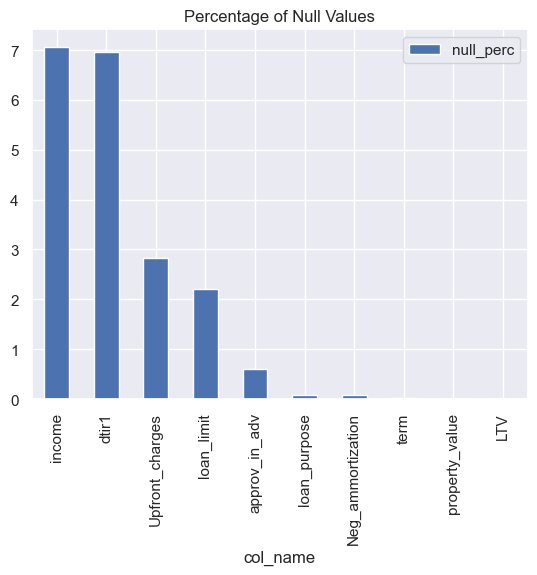

In [16]:
status_null_val(df, status_value=0)

From the information extracted above, we find that the null values that are contained in rows with 'Status' = 0 are roughly coherent with the overall distribution of null values within the dataset. Therefore, they are no cause for concern, they just need to be dealt with appropriately.

Number of rows with Status 1 = 36639


,col_name,data_type,null_num,null_perc
11,Interest_rate_spread,float64,36639,100.00
12,Upfront_charges,float64,36486,99.58
10,rate_of_interest,float64,36439,99.45
32,dtir1,float64,16310,44.52
17,property_value,float64,15096,41.20
28,LTV,float64,15096,41.20
22,income,float64,1239,3.38
1,loan_limit,object,881,2.40
3,approv_in_adv,object,241,0.66
26,age,object,200,0.55


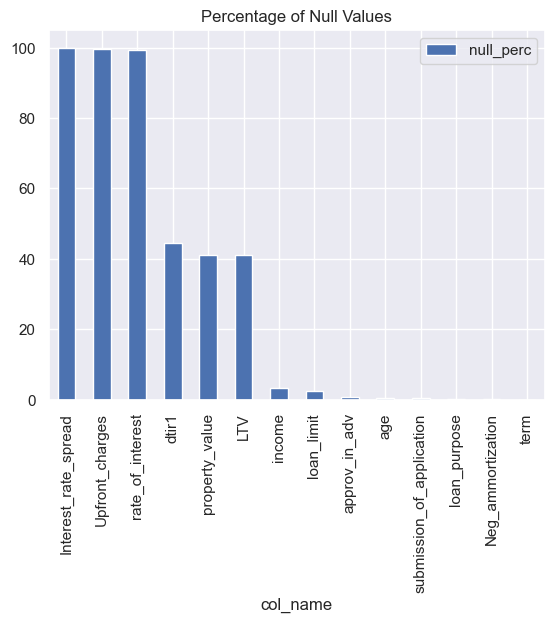

In [17]:
# Displaying the number and how many of the rows with 'Status 1' have missing values
status_null_val(df, status_value=1)

Looking at missing values with 'Status' = 1 instead, we find that the features listed below exhibit missing values in a concerningly high percentage of rows with such label. Specifically, they are:

- Interest_rate_spread
- Upfront_charges
- rate_of_interest
- dtir1
- property_value
- LTV

Since they represent such a large percentage of our class, it is very likely that they will cause overfitting when running our models. Even if this doesn't happen, we want to avoid that the model learns that whenever missing values are present in a certain feature, say 'Interest_rate_spread', then the load defaults, which would hold no explanatory power, as this interpretation would be based off an issue with our dataset.

We have explored the option of imputing such missing values with both simple imputing strategies (substituting with mean/median) and KNN imputation. However, both these strategies do not solve the underlying issue we have as having such a high incidence of missing values in a single feature means that imputation has no data to estimate values capturing the characteristics determining 'Status' = 1 and so the resulting imputations would have no more explanatory power than leaving missing values untreated.

Therefore, our final choice has been to remove these features from our evaluation altogether, and drop the rest of the missing values which constitute about 9% of the dataset, which, being very large, still has enough data for models to produce significant predictions.

We also take the chance to drop the column 'ID', useless for our purposes.

In [18]:
# Dropping selected columns and the rest of null values
def preprocess_drop_null(df):
    df_dropped = df.drop(['Interest_rate_spread', 'Upfront_charges', 'rate_of_interest', 'dtir1', 'property_value', 'LTV', 'ID'],axis=1).dropna()

    return df_dropped

## Preprocessing


### Outlier Handling with Transformations
From the plots above, we see that we have a high number of outliers and positive skewness for the features 'loan_amount' and 'income'. Since our analysis is inherently based on outliers (since loan defaults are far more uncommon than loans that do not) it is not wise to remove them. It is appropriate instead to apply a transformation (we have chosen log transformation), to bring them closer to the mean, mitigating their detrimental effect on model training but retaining some if not most of their explanatory power.

In [19]:
def preprocess_outliers(df):

  columns_to_log = ['loan_amount', 'income']
  for col in columns_to_log:
      insert_index = df.columns.get_loc(col)
      df.insert(insert_index + 1, col + ' (LOG)', df[col].apply(lambda x: np.log(x + 1)))
      df.drop(col, axis=1, inplace=True)

  return df

### Normalizing

This step has to come after having applied log to make the distributions more normal. Indeed, if we standardize first, the outliers will still have a significant effect on the mean and standard deviation, potentially leading to less effective standardization.

In [20]:
from sklearn.preprocessing import StandardScaler

def preprocess_normalization(df):
    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Selecting numerical columns excluding 'Status'
    numerical_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Status']

    # Applying StandardScaler to the numerical columns
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    return df

### Encoding

The following columns were encoded using one-hot encoding as there is no natural ordered relationship between such categories that needs to be captured:

- 'loan_limit',
- 'Gender',
- 'approv_in_adv',
- 'loan_type',
- 'loan_purpose'
- 'Credit_Worthiness',
- 'open_credit',
- 'business_or_commercial',
- 'Neg_ammortization',
- 'interest_only',
- 'lump_sum_payment',
- 'construction_type',
- 'occupancy_type',
- 'Secured_by',
- 'credit_type',
- 'co-applicant_credit_type',
- 'submission_of_application',
- 'Region',
- 'Security_Type'

For columns 'age' and 'total_units' instead, there is an ordered relationship to be preserved and therefore it has been encoded using labels.




In [21]:
# Encoding non-numerical variables
from sklearn.preprocessing import LabelEncoder

def preprocess_encoding(df, onehot_cols, label_cols):
    # OneHotEncoding
    df_encoded = pd.get_dummies(data=df, columns=onehot_cols, dtype='int')

    # Label Encoding
    for feature in label_cols:
        le = LabelEncoder()
        df_encoded[f'{feature}_label'] = le.fit_transform(df_encoded[feature])
        print(f'label classes: {le.classes_}')

    df_encoded.drop(columns=['age', 'total_units'], inplace=True)

    return df_encoded

### Handling Dataset Imbalance

Handling dataset imbalance was perhaps the biggest issue we encountered while analyzing this dataset.
After much deliberation and considering other options we settled on rebalancing our dataset using Synthetic Minority Oversampling Technique (SMOTE).

SMOTE is an algorithm that performs data augmentation by creating synthetic data points based on the original data points, in an advanced version of ovesampling. The advantage of SMOTE is that you are not generating duplicates, but rather creating synthetic data points that are slightly different from the original data points, preventing overfitting.

In general, this algorithm works as follows:
- You draw a random sample from the minority class.
- For the observations in this sample, you will identify the k nearest neighbors.
- You will then take one of those neighbors and identify the vector between the current data point and the selected neighbor.
- You multiply the vector by a random number between 0 and 1.
- To obtain the synthetic data point, you add this to the current data point.

Theoretically, implementing SMOTE reduces false negatives, at the cost of increasing false positives. This results in an increase in recall, at the cost of lower precision. This means that we will add more predictions of the minority class: some of them correct (increasing recall), but some of them wrong (decreasing precision). Looking at our objective of predicting loan defaults, minimizing false negatives is of primary importance, as they are mistakes more likely to hurt the bottom line. Furthermore, accuracy could decrease, but such metric should not be our main performance evaluator when looking at imbalanced datasets.

https://towardsdatascience.com/smote-fdce2f605729

In [22]:
#https://medium.com/geekculture/mastering-loan-default-prediction-tackling-imbalanced-datasets-for-effective-risk-assessment-8e8dfb2084d0
#Fixing the imbalance using SMOTE Technique
from imblearn.over_sampling import SMOTE

def preprocess_imbalance(df, target):
    df2 = df.copy()

    print('Original class distribution:')
    print(df2[target].value_counts())

    xf = df2.columns
    X = df2.drop([target],axis=1)
    Y = df2[target]

    smote = SMOTE()
    X, Y = smote.fit_resample(X, Y)

    df2 = pd.DataFrame(X, columns=xf)
    df2[target] = Y

    print('\nClass distribution after applying SMOTE Technique:',)
    print(Y.value_counts())

    return df2

### Full Preprocessing

We have collected all the data preprocessing performed above in one neat function.

In [23]:
def preprocessing(df, onehot_cols, label_cols, smote=True):
    df = preprocess_drop_null(df)
    df = preprocess_outliers(df)
    df = preprocess_normalization(df)
    df = preprocess_encoding(df, onehot_cols, label_cols)

    if smote == True:
        df = preprocess_imbalance(df, target='Status')

    return df

In [24]:
cat_cols = ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit',
            'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type',
            'occupancy_type', 'Secured_by', 'credit_type', 'co-applicant_credit_type', 'submission_of_application',
            'Region', 'Security_Type']

label_cols = ['age', 'total_units']

df_SMOTE = preprocessing(df, cat_cols, label_cols, smote=True)

df_SMOTE

label classes: ['25-34' '35-44' '45-54' '55-64' '65-74' '<25' '>74']
label classes: ['1U' '2U' '3U' '4U']
Original class distribution:
0    100881
1     34227
Name: Status, dtype: int64

Class distribution after applying SMOTE Technique:
1    100881
0    100881
Name: Status, dtype: int64


,loan_amount (LOG),term,income (LOG),Credit_Score,Status,loan_limit_cf,loan_limit_ncf,Gender_Female,Gender_Joint,Gender_Male,...,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct,age_label,total_units_label
0,-1.529059,0.439777,-1.070768,0.502618,1,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
1,-0.539321,0.439777,-0.055230,-1.275460,1,1,0,0,0,1,...,0,1,1,0,0,0,0,1,3,0
2,0.631756,0.439777,0.566610,1.158608,0,1,0,0,0,1,...,0,1,0,0,0,1,0,1,1,0
3,0.832338,0.439777,0.784611,-0.973360,0,1,0,0,0,1,...,1,0,1,0,0,0,0,1,2,0
4,1.562839,0.439777,0.659791,-0.843888,0,1,0,0,1,0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201757,0.713644,0.439777,-0.594171,1.263833,1,1,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
201758,1.802318,-0.337749,1.424944,-1.201948,1,0,1,0,0,1,...,1,0,1,0,0,0,0,1,3,0
201759,-1.224309,-2.568908,0.187025,0.907642,1,1,0,0,0,1,...,0,1,1,0,0,0,0,1,3,0
201760,0.184910,-2.568908,0.421151,0.019538,1,1,0,0,0,0,...,0,1,0,0,0,1,0,1,3,0




Shape of the dataframe: (201762, 4)




C:\Users\Markou\AppData\Local\Temp\ipykernel_31880\3558614591.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


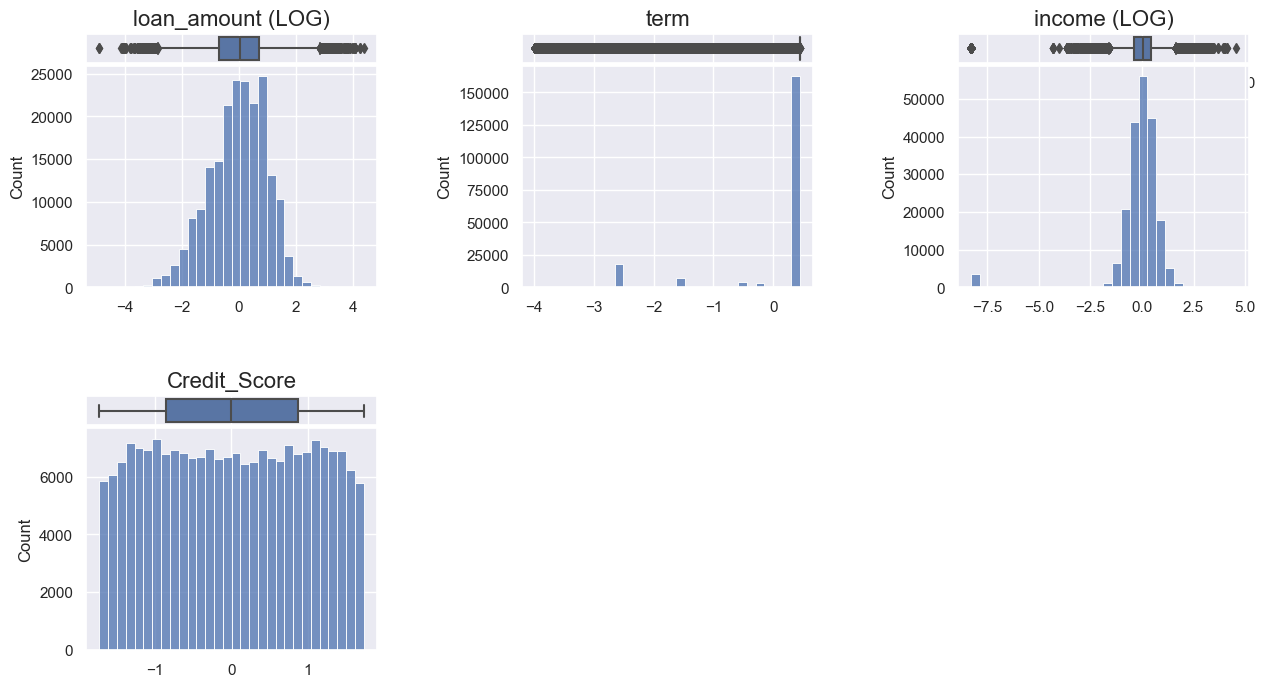

In [25]:
plot_columns(df_SMOTE[['loan_amount (LOG)', 'term', 'income (LOG)', 'Credit_Score']])

In [26]:
df_noSMOTE = preprocessing(df, cat_cols, label_cols, smote=False)

df_noSMOTE

label classes: ['25-34' '35-44' '45-54' '55-64' '65-74' '<25' '>74']
label classes: ['1U' '2U' '3U' '4U']


,loan_amount (LOG),term,income (LOG),Credit_Score,Status,loan_limit_cf,loan_limit_ncf,Gender_Female,Gender_Joint,Gender_Male,...,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct,age_label,total_units_label
0,-1.529059,0.439777,-1.070768,0.502618,1,1,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0
1,-0.539321,0.439777,-0.055230,-1.275460,1,1,0,0,0,1,...,0,1,1,0,0,0,0,1,3,0
2,0.631756,0.439777,0.566610,1.158608,0,1,0,0,0,1,...,0,1,0,0,0,1,0,1,1,0
3,0.832338,0.439777,0.784611,-0.973360,0,1,0,0,0,1,...,1,0,1,0,0,0,0,1,2,0
4,1.562839,0.439777,0.659791,-0.843888,0,1,0,0,1,0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,0.754874,-2.568908,0.385586,-0.351895,0,1,0,0,0,0,...,0,1,0,0,0,1,0,1,3,0
148666,1.265618,0.439777,0.292781,-1.128726,0,1,0,0,0,1,...,1,0,0,0,0,1,0,1,0,3
148667,0.794040,-2.568908,0.259753,0.019257,0,1,0,0,0,1,...,1,0,1,0,0,0,0,1,2,0
148668,-0.625149,-2.568908,0.292781,0.321358,0,1,0,1,0,0,...,0,1,1,0,0,0,0,1,3,0




Shape of the dataframe: (135108, 4)



C:\Users\Markou\AppData\Local\Temp\ipykernel_31880\3558614591.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


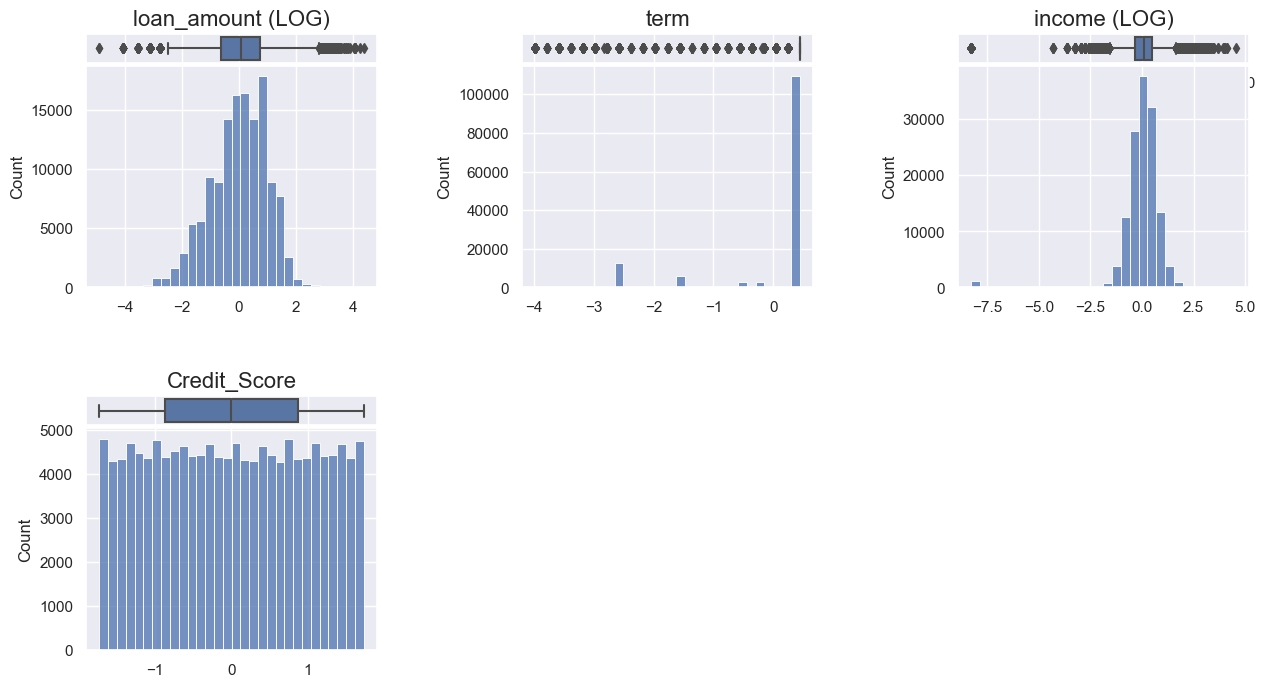

In [27]:
plot_columns(df_noSMOTE[['loan_amount (LOG)', 'term', 'income (LOG)', 'Credit_Score']])

# Models and evaluation

In this section we are going to create, tune, and evaluate different classification models.

The structure that we are going to use across all of our models is:
- Randomized Grid Search Cross-Validation. In this case we use Randomized Grid Search since the gridsearch execution time tends to be extremely long for most of the models.
- Stratified K-Fold Cross Validation.
  - Instead of the normal cross-validation algorithm we will use Stratified CV.
  - We choose that since we are dealing with a classification problem and if we randomly split our data, we might get uneven distribution of labels. Stratified CV prevents that from happening.
- Create models based on both SMOTE and no_SMOTE data sets
- Evaluate and store the best performing parameters for each model.
- Create feature importance plot where applicable.


We start by dividing the two dataframes 'df_SMOTE' and 'df_noSMOTE' into training and testing, in order to compare performance before and after implementing the SMOTE algorithm. 

We will also use 4 different models. The models we chose are:
- Logistic Regression
- Random Forest
- XGBoost 
- LightGBM

Those models balance the tradeoff between performance and intrepretability. Having 4 models and 2 different datasets we will run our models a total of 8 times.

In [36]:
from sklearn.model_selection import train_test_split
# Extract the feature columns (X_SMOTE)
X_SMOTE = df_SMOTE.drop(columns=['Status'])

# Extract the target column (Y_SMOTE)
Y_SMOTE = df_SMOTE['Status']

In [29]:
X_SMOTE_train, X_SMOTE_test, y_SMOTE_train, y_SMOTE_test = train_test_split(X_SMOTE, Y_SMOTE, test_size=0.3, random_state=0)

In [30]:
# Extract the feature columns (X_noSMOTE)
X_noSMOTE = df_noSMOTE.drop(columns=['Status'])

# Extract the target column (Y_noSMOTE)
Y_noSMOTE = df_noSMOTE['Status']

In [31]:
X_noSMOTE_train, X_noSMOTE_test, y_noSMOTE_train, y_noSMOTE_test = train_test_split(X_noSMOTE, Y_noSMOTE, test_size=0.3, random_state=0)

- We also create an evaluation function using accuracy as our metric of choice.

In [32]:
# Evaluation function
def evaluation(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

- Let's import everything we need for the analysis

In [33]:
# The GridSearch and the Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# The models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

- Also let's create out stratified cross validator with 5 splits.

In [34]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Model: Logistic Regression

- A classic in machine learning classification, we decided to use logistic regression since it is one of the most interpretable methods, its fast to train, and it would give us a nice benchmark to start our model training journey.
- We use regularization parameter to account for overfitting.
- Also, since the training is fast and the parameter is only 1, we will use an normal grid search 

#### Logistic Regression noSMOTE Dataset 

In [37]:
## LOGISTIC REGRESSION ON 'df_noSMOTE'

# Initialize the parameter grid.
param_grid = {
    'C': [0.01, 0.1, 0, 1, 10],  # Regularization parameter
}

# logistic regression model.
model = LogisticRegression(solver='lbfgs', max_iter=300) # lbfgs is the recommended solver for big data sets.

# Initialize GSCV and train model
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='recall', verbose = 0)
grid_search.fit(X_noSMOTE_train, y_noSMOTE_train)

c:\Users\Markou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Markou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=300),
             param_grid={'C': [0.01, 0.1, 0, 1, 10]}, scoring='recall')

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Find the best parameters and the best score achieved
print("EVALUATING LOGISTIC REGRESSION ON 'df_noSMOTE'")
print("Best Params: " + str(grid_search.best_params_))
print("Best score: " + str(grid_search.best_score_))

best_model = grid_search.best_estimator_
evaluation(y_noSMOTE_test, best_model.predict(X_noSMOTE_test))

EVALUATING LOGISTIC REGRESSION ON 'df_noSMOTE'
Best Params: {'C': 10}
Best score: 0.4961327552221252
Accuracy: 0.8643080946389362
Confusion Matrix:
 [[29893   332]
 [ 5168  5140]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.92     30225
           1       0.94      0.50      0.65     10308

    accuracy                           0.86     40533
   macro avg       0.90      0.74      0.78     40533
weighted avg       0.87      0.86      0.85     40533


- As we can see with the imbalanced dataset logistic regression performs poorly, having 50% recall on our target label. Of course, this is the imbalanced dataset so maybe a model trained in the balanced dataset will perform better.

#### Logistic Regression SMOTE Dataset 

In [39]:
## LOGISTIC REGRESSION ON 'df_SMOTE'

# Initialize the parameter grid.
param_grid = {
    'C': [0.01, 0.1, 0, 1, 10],  # Regularization parameter
}

# logistic regression model.
model = LogisticRegression(solver='lbfgs', max_iter=200) # lbfgs is the recommended solver for big data sets.

# Initialize GSCV and train model
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='recall', verbose = 0)
grid_search.fit(X_SMOTE_train, y_SMOTE_train)

c:\Users\Markou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Markou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=200),
             param_grid={'C': [0.01, 0.1, 0, 1, 10]}, scoring='recall')

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Find the best parameters and the best score achieved
print("EVALUATING LOGISTIC REGRESSION ON 'df_SMOTE'")
print("Best Params: " + str(grid_search.best_params_))
print("Best score: " + str(grid_search.best_score_))

best_model = grid_search.best_estimator_
evaluation(y_SMOTE_test, best_model.predict(X_SMOTE_test))

EVALUATING LOGISTIC REGRESSION ON 'df_SMOTE'
Best Params: {'C': 0.1}
Best score: 0.7242965743785666
Accuracy: 0.8446199342463943
Confusion Matrix:
 [[28992  1094]
 [ 8311 22132]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86     30086
           1       0.95      0.73      0.82     30443

    accuracy                           0.84     60529
   macro avg       0.87      0.85      0.84     60529
weighted avg       0.87      0.84      0.84     60529


We can see that logistic regression has a good accuracy overall (0.845). Considering our specific case, the best metric to focus on is the recall, as our objective is to limit false negatives (i.e., loans that default that are classified as non-defaulters) as much as possible. Therefore, when implementing other models below, we will be primarily looking for an improvement in the recall score for class 1 (greater than 0.73, the baseline generated from logistic regression), even if some accuracy is sacrificed.

### Model: XGBoost

Now we move on to XGBoost. This is a way more advanced model than logistic regression, being an advanced implementation of gradient boosting algorithm. 

- For the configuration of the problem and the hyperparameter grid, we set the objective to <code>binary:logistic</code> since we have only 2 classes. Then we choose a variety of hyperparameters that through testing where found to impact the results the most.Specifically, we employed small learning rates with high numbers of estimators for accuracy improvement and introduced L1 and L2 regularization to prevent overfitting.

#### XGBoost noSMOTE Dataset 

In [ ]:
## XGBOOST ON 'df_noSMOTE'

# Initialize the parameter grid.

xgboost_param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],   # Controls step size, prevents overfitting
    'n_estimators': [100, 500, 1000],    # Number of boosted trees
    'max_depth': [3, 4, 5, 6],           # Maximum depth of each tree
    'min_child_weight': [1, 2, 3, 4],    # Minimum sum of instance weight needed in child
    'gamma': [0, 0.1, 0.2],              # Minimum loss reduction required for split
    'reg_alpha': [0, 0.1, 0.2],          # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]            # L2 regularization term on weights
}


# XGBoost model for classification with 2 classes.
model = XGBClassifier(objective = 'binary:logistic', num_class=1, random_state=0, n_jobs=-1)

# Initialize GSCV and train model
grid_search = RandomizedSearchCV(estimator=model, param_distributions= xgboost_param_grid, cv= cv,\
                                 verbose= -1, random_state=0, n_iter = 20, error_score='raise')
grid_search.fit(X_noSMOTE_train, y_noSMOTE_train)

# Find the best parameters and the best score achieved
print("Best Params: " + str(grid_search.best_params_))
print("Best score: " + str(grid_search.best_score_))

Best Params: {'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
Best score: 0.8744594237377743


In [ ]:
XGBoost_best_model = grid_search.best_estimator_
evaluation(y_noSMOTE_test, XGBoost_best_model.predict(X_noSMOTE_test))

Accuracy: 0.8740038980583722
Confusion Matrix:
 [[29837   388]
 [ 4719  5589]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92     30225
           1       0.94      0.54      0.69     10308

    accuracy                           0.87     40533
   macro avg       0.90      0.76      0.80     40533
weighted avg       0.88      0.87      0.86     40533


A few things to note from the results:
- Due to the imbalancing of the classes, the recall stays very low close to 55%. 
- Even if you use a way more complex model we need to fix the dataset before we employ models.

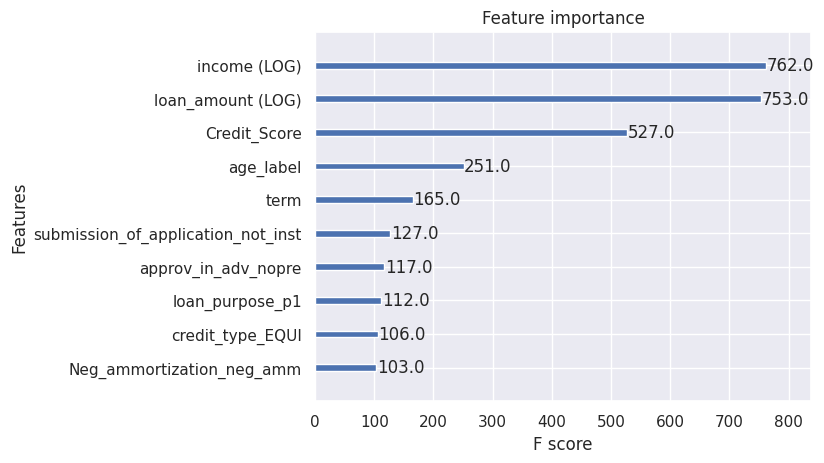

In [ ]:
# plot feature importance
plot_importance(XGBoost_best_model, max_num_features=10)
plt.show()

- Looking at the feature importance, <b>income</b>, <b>loan_amount</b>, <b>credit_limit</b>, and <b>age</b> seem to be the key features behind the decision making of our model.

#### XGBoost SMOTE Dataset 

In [42]:
## XGBOOST ON 'df_SMOTE'

# XGBoost model for classification with 2 classes.
model = XGBClassifier(objective = 'binary:logistic', num_class=1, random_state=0, n_jobs=-1)

# Initialize GSCV and train model
grid_search = RandomizedSearchCV(estimator=model, param_distributions= xgboost_param_grid, cv= cv,\
                                 verbose= -1, random_state=0, n_iter = 20, error_score='raise')
grid_search.fit(X_SMOTE_train, y_SMOTE_train)

# Find the best parameters and the best score achieved
print("Best Params: " + str(grid_search.best_params_))
print("Best score: " + str(grid_search.best_score_))

Best Params: {'reg_lambda': 1.5, 'reg_alpha': 0.2, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0}
Best score: 0.8911798027245125


In [43]:
XGBoost_SMOTE_best_model = grid_search.best_estimator_
evaluation(y_SMOTE_test, XGBoost_SMOTE_best_model.predict(X_SMOTE_test))

Accuracy: 0.8927125840506204
Confusion Matrix:
 [[29160   926]
 [ 5568 24875]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90     30086
           1       0.96      0.82      0.88     30443

    accuracy                           0.89     60529
   macro avg       0.90      0.89      0.89     60529
weighted avg       0.90      0.89      0.89     60529


- Using the balanced dataset we can see that the performance of our model improves greatly, reaching 82% recall from 54%!
- Also the accuracy greatly increases.

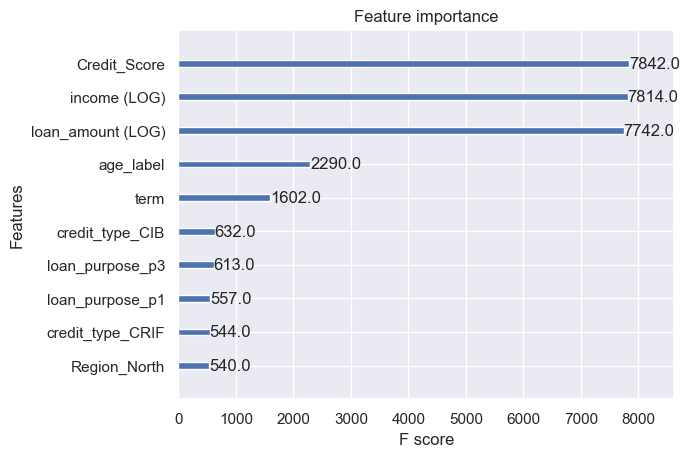

In [44]:
# plot feature importance
plot_importance(XGBoost_SMOTE_best_model, max_num_features=10)
plt.show()

- This time <b>income</b>, <b>loan_amount</b>, <b>credit_limit</b> seem to be the most influancial features.

### Model: Random Forest Classifier

An ensemble learning method combining multiple decision trees.
Each tree contributes a "vote" towards the final prediction.
Hyperparameter Tuning:

- min_samples_split: Varied to determine the optimal number of samples for node splitting, aiming to prevent overfitting.
- n_estimators and max_depth: Adjusted to strike a balance between performance and overfitting.

#### Random Forest noSMOTE Dataset 

In [67]:
# The gridSearch below was found from the following article
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False
             ]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rfc = RandomForestClassifier(random_state=42,n_jobs=-1)
CV_rfc = RandomizedSearchCV(estimator=rfc, param_distributions= random_grid, cv= cv,\
                            verbose= -1, random_state=0, n_iter = 20)
CV_rfc.fit(X_noSMOTE_train, y_noSMOTE_train)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 233, 266, 300,
                                                         333, 366, 400, 433,
                                                         466, 500]},
                   random_state=0, verbose=-1)

In [68]:
print("Best Params: " + str(CV_rfc.best_params_))
print("Best score: " + str(CV_rfc.best_score_))

CV_rfc_best_model = CV_rfc.best_estimator_
evaluation(y_noSMOTE_test, CV_rfc_best_model.predict(X_noSMOTE_test))

Best Params: {'n_estimators': 366, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 100, 'bootstrap': True}
Best score: 0.8694369547977796
Accuracy: 0.8709693336293884
Confusion Matrix:
 [[29859   366]
 [ 4864  5444]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92     30225
           1       0.94      0.53      0.68     10308

    accuracy                           0.87     40533
   macro avg       0.90      0.76      0.80     40533
weighted avg       0.88      0.87      0.86     40533


- The results, since we are using the imbalanced dataset, are similar to the XGBoost and Logistic Regression.

In [69]:
def rf_feature_importances(model, feature_names):
    # Get feature importances
    importances = model.feature_importances_
    # feature_names = X_noSMOTE_train.columns.tolist()
    # Sort the feature importances in descending order and get the top 10
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:10]

    # Plot the top 10 features
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[top_indices], y=np.array(feature_names)[top_indices])
    plt.title('Top 10 Feature Importances in Random Forest Model')
    plt.xlabel('Relative Importance')
    plt.show()

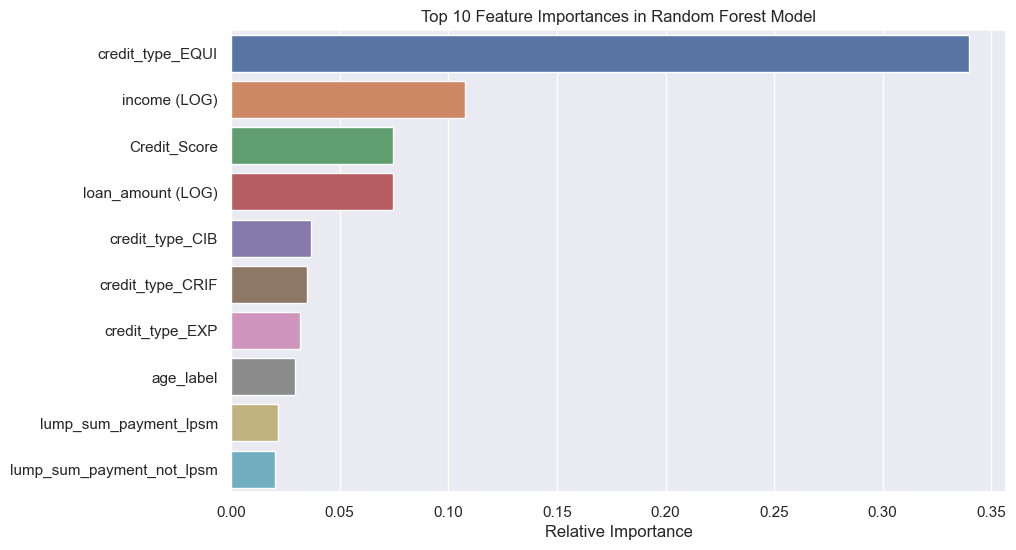

In [70]:
# plot feature importance
feature_names = X_noSMOTE_train.columns.tolist()
rf_feature_importances(CV_rfc_best_model, feature_names)

- What is very interesting here is that Random Forest model seems to find the <b>credit_type_EQUI</b> as an important feature, while XGBoost did not. 
- In general, all credit types rank high, while the age label is left behind.
- Once more <b>income</b>, <b>loan_amount</b>, <b>credit_limit</b> rank at the top of the influence table.

#### Random Forest SMOTE Dataset 

In [71]:
CV_rfc.fit(X_SMOTE_train, y_SMOTE_train)
print("Best Params: " + str(CV_rfc.best_params_))
print("Best score: " + str(CV_rfc.best_score_))

CV_rfc_best_model = CV_rfc.best_estimator_
evaluation(y_SMOTE_test, CV_rfc_best_model.predict(X_SMOTE_test))

Best Params: {'n_estimators': 433, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40, 'bootstrap': True}
Best score: 0.8790155078938053
Accuracy: 0.8866328536734458
Confusion Matrix:
 [[27995  2091]
 [ 4771 25672]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89     30086
           1       0.92      0.84      0.88     30443

    accuracy                           0.89     60529
   macro avg       0.89      0.89      0.89     60529
weighted avg       0.89      0.89      0.89     60529


- We see an improvement of 2% from the XGBoost model going to 84% recall on the target labe, further reducing false positives.
- But, the recall for label 0 also got decreased.
- The accuracy remained the same.

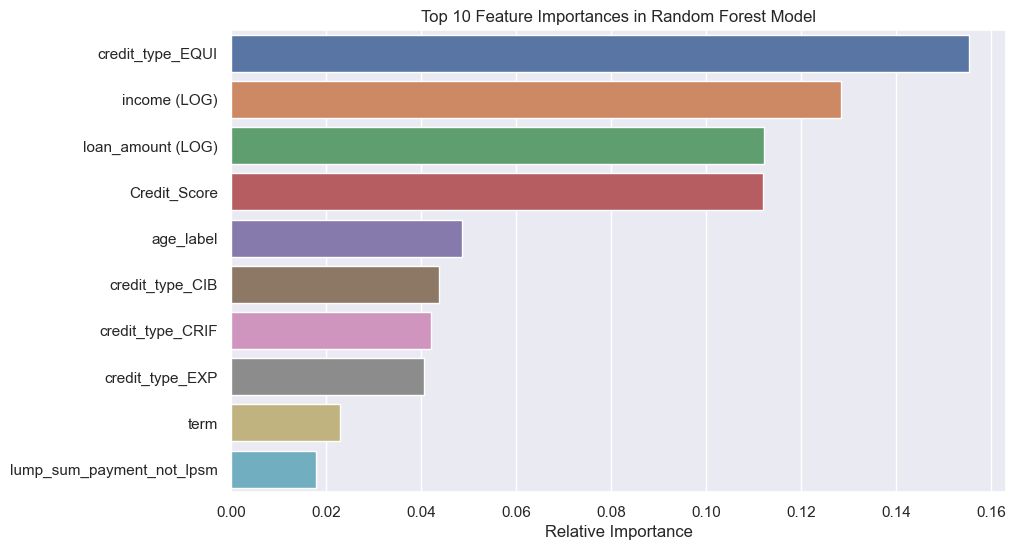

In [72]:
# plot feature importance
feature_names = X_SMOTE_train.columns.tolist()
rf_feature_importances(CV_rfc_best_model, feature_names)

- Now the results look way more balanced, with our influencing features remaining the same, but having the same influence at the top.

### Model: LightGBM

Finally the last model we are going to use is LightGBM, an advanced implementation of the gradient boosting algorithm.

- Boosting Method: Contrary to Random Forests, LightGBM builds one tree at a time. Each subsequent tree corrects the mistakes of its predecessor.
- Hyperparameter Adjustment: Employed small learning rates with high numbers of estimators for accuracy improvement.
- Introduced L1 and L2 regularization to prevent overfitting.

#### LightGBM SMOTE Dataset 

In [46]:
# Hyper parameter tips when using LightGBM
# https://neptune.ai/blog/lightgbm-parameters-guide
# Also very useful video https://www.youtube.com/watch?v=TvB_3jVIHhg

# 1) The num_leaves = 2^max_depth
# 2) Num_iterations (Also called num_boost_round), specifies the number of boosting trees to build. Always start small and steadily go up.
#    Also it is recommended to use SMALL learning_rate with BIG num_iterations.
# 3) Use early_stopping_rounds to stop your model when it is not significantly learning.
#    Rule of thumb: 10% of the numbers of iterations.
# 4) For categorical values, we need to do a special type of pre-processing.
# 5) Method for the metric include (For classification problems) : AUC, multilogloss, multi_error
# 6) boosting_type include 3 types: gbdt, dart, goss

params = {
    'learning_rate': [0.05,0.1,0.05],
    "max_depth": [12 ,18,24],
    "num_leaves": [40, 48, 60],
    'reg_alpha': [0,0.1],
    'reg_lambda': [0, 0.1],
    'num_iterations': [100,300,500]
    }

params_fixed ={
    'objective': 'binary',
    'boosting_type':'gbdt',
    'random_state':1
    }


In [48]:
# The follwing procudure follows the steps of this site
# https://www.geeksforgeeks.org/cross-validation-and-hyperparameter-tuning-of-lightgbm-model/

#Create our model. In this case it is a LightGDM Classifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Initialize our model
lgb_cl = lgb.LGBMClassifier(**params_fixed, n_jobs=-1)

# Initialize our GridSearchCV for hyperparameters
gs = RandomizedSearchCV(estimator=lgb_cl, param_distributions= params, cv=cv, \
                        random_state=0, scoring='accuracy', n_jobs=-1, verbose=-1, n_iter = 100)

# In the fit, we give the evaluation set
gs.fit(X_SMOTE_train, y_SMOTE_train)


print("Best Params: " + str(gs.best_params_))
print("Best score: " + str(gs.best_score_))

c:\Users\Markou\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 70438, number of negative: 70795
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 141233, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498736 -> initscore=-0.005055
[LightGBM] [Info] Start training from score -0.005055
Best Params: {'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 60, 'num_iterations': 500, 'max_depth': 12, 'learning_rate': 0.1}
Best score: 0.9064170481563391


In [50]:
LightGBM_best_SMOTE_model = gs.best_estimator_
evaluation(y_SMOTE_test, LightGBM_best_SMOTE_model.predict(X_SMOTE_test))

Accuracy: 0.9076310528837417
Confusion Matrix:
 [[29375   711]
 [ 4880 25563]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.91     30086
           1       0.97      0.84      0.90     30443

    accuracy                           0.91     60529
   macro avg       0.92      0.91      0.91     60529
weighted avg       0.92      0.91      0.91     60529


- Best of both worlds!
- LightGBM achieves great results in the SMOTE dataset, achieving both 90% accuracy with 84% recall on the target label which is better than our previous models.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

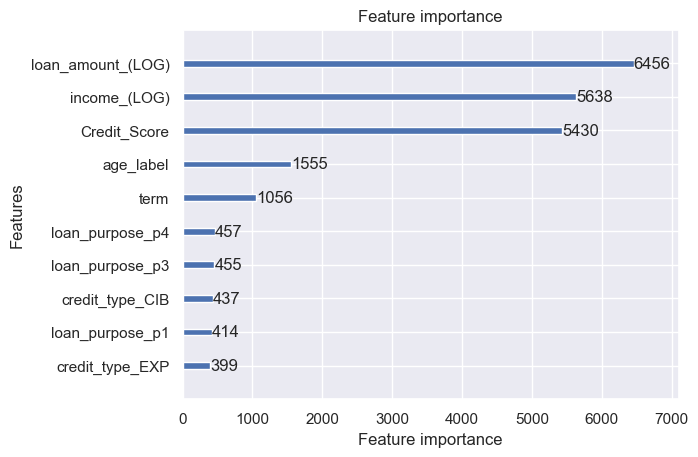

In [55]:
# plot feature importance
lgb.plot_importance(LightGBM_best_SMOTE_model, max_num_features=10)

- The feature importance seems to be set and done.
- The most influencial features are

#### LightGBM noSMOTE Dataset 

In [51]:
# In the fit, we give the evaluation set
gs.fit(X_noSMOTE_train, y_noSMOTE_train)


print("Best Params: " + str(gs.best_params_))
print("Best score: " + str(gs.best_score_))

c:\Users\Markou\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 23919, number of negative: 70656
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 94575, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.252910 -> initscore=-1.083150
[LightGBM] [Info] Start training from score -1.083150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Params: {'reg_lambda': 0, 'reg_alpha': 0.1, 'num_leaves': 60, 'num_iterations': 300, 'max_depth': 12, 'learning_rate': 0.05}
Best score: 0.8740681998413958


In [54]:
LightGBM_best_no_SMOTE_model = gs.best_estimator_
evaluation(y_noSMOTE_test, LightGBM_best_no_SMOTE_model.predict(X_noSMOTE_test))

Accuracy: 0.8743986381466953
Confusion Matrix:
 [[29820   405]
 [ 4686  5622]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92     30225
           1       0.93      0.55      0.69     10308

    accuracy                           0.87     40533
   macro avg       0.90      0.77      0.80     40533
weighted avg       0.88      0.87      0.86     40533


- Once more, when we train on the normal dataset, we achieve only 55% recall on the target label.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

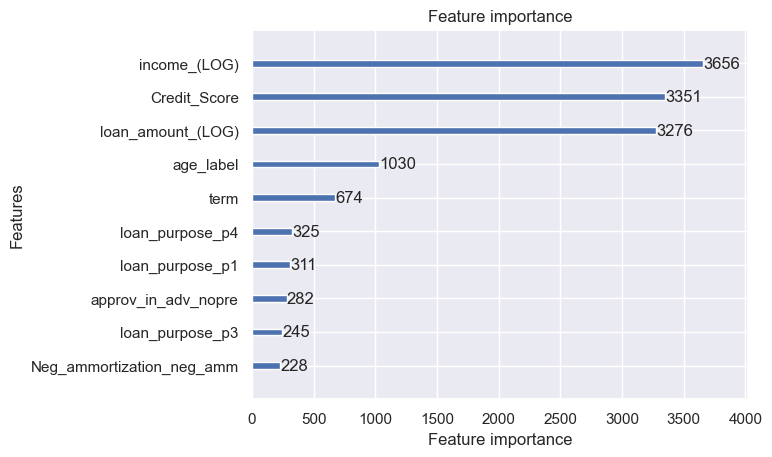

In [56]:
lgb.plot_importance(LightGBM_best_no_SMOTE_model, max_num_features=10)